<a href="https://colab.research.google.com/github/Jinhyungnam/Project1/blob/main/gas_MLP_Fianl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"dsdszzz","key":"fdb5fcc330df3b6a4683c4dc90b77a94"}'}

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c 2022-samsung-ds-competition-co-gas-data

2022-samsung-ds-competition-co-gas-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

 2022-samsung-ds-competition-co-gas-data.zip   sample_solution.csv
'kaggle (1).json'			       test_data.csv
 kaggle.json				       tmp_checkpoint_mlp_train_shft.h5
 predicted_output.csv			       train_data.csv
 sample_data


In [ ]:
!unzip 2022-samsung-ds-competition-co-gas-data.zip

Archive:  2022-samsung-ds-competition-co-gas-data.zip
replace sample_solution.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)
from sklearn.linear_model import LinearRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
training_data = pd.read_csv('train_data.csv')
test_input_data = pd.read_csv('test_data.csv')

In [ ]:
# Column Selection
cols = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16']
# cols = ['s9', 's11', 's13', 's15']
# cols = ['s1', 's9', 's11', 's13', 's15']
# cols = ['s1', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16']

In [ ]:
# Signal shift
for s in cols:
    training_data['shf_{}'.format(s)] = training_data['{}'.format(s)].shift(-2000)
    test_input_data['shf_{}'.format(s)] = test_input_data['{}'.format(s)].shift(-2000)
training_data = training_data.dropna()
test_input_data = test_input_data.fillna(0)

In [ ]:
train_x = np.array(training_data.values[:,19:], dtype=np.float64)
train_y = np.array(training_data.values[:,2], dtype=np.float64)
test_x = np.array(test_input_data.values[:,18:], dtype=np.float64)
# test_x = np.array(test_input_data.values[:,2:], dtype=np.float64)

In [ ]:
# def arr_agg_by_sliding_window(arr: np.ndarray, _agg_func: str, window_size):
#     """
#     MIN    | 'min'
#     MAX    | 'max'
#     MEDIAN | 'med'
#     MEAN   | 'avg'
#     """
#     from scipy.ndimage.filters import (minimum_filter, maximum_filter, median_filter)
#     # from scipy.ndimage import uniform_filter # 

#     if _agg_func in ('min', 'max', 'med'):
#         if _agg_func == 'min': agg_func = minimum_filter
#         if _agg_func == 'max': agg_func = maximum_filter
#         if _agg_func == 'med': agg_func = median_filter
#         dim_a = len(arr.shape)
#         N, M = 1, window_size
#         if dim_a == 1:
#             P, Q = len(arr), 1
#             maxs = agg_func(arr.reshape((-1, 1)), size=(M, N))
#         elif dim_a == 2:
#             P,Q = arr.shape
#             maxs = agg_func(arr, size=(M, N))
#         ret = maxs[M//2:(M//2)+P-M+1, N//2:(N//2)+Q-N+1]
        
#         if dim_a == 1:
#             return ret.reshape((-1))
#         if dim_a == 2:
#             ret = np.pad(ret, ((0,arr.shape[0]-ret.shape[0]),(0,0)), 'constant', constant_values=0)
#             return ret
    
#     else: # moving average
#         import bottleneck as bn
#         ret = bn.move_mean(arr, window = window_size, axis=0)[window_size-1:]
#         ret = np.pad(ret, ((0,arr.shape[0]-ret.shape[0]),(0,0)), 'constant', constant_values=0)
#         return ret

# # a = np.random.randint(1, 23, size=(6,4))
# # print(a)
# # aa = arr_agg_by_sliding_window(a, 'aaa', 3)
# # aa

In [ ]:
# interval = 10 #10
# # train_x_min = arr_agg_by_sliding_window(train_x, 'min', interval)
# # train_x_max = arr_agg_by_sliding_window(train_x, 'max', interval)
# # train_x_med = arr_agg_by_sliding_window(train_x, 'med', interval)
# train_x_avg = arr_agg_by_sliding_window(train_x, 'avg', interval)

# train_x = np.concatenate([train_x, train_x_avg],1)
# # train_x = np.concatenate([train_x, train_x_min, train_x_max, train_x_med, train_x_avg],1)

In [ ]:

# test_x_min = arr_agg_by_sliding_window(test_x, 'min', interval)
# test_x_max = arr_agg_by_sliding_window(test_x, 'max', interval)
# test_x_med = arr_agg_by_sliding_window(test_x, 'med', interval)
# test_x_avg = arr_agg_by_sliding_window(test_x, 'avg', interval)

# test_x = np.concatenate([test_x, test_x_avg],1)

# test_x = np.concatenate([test_x, test_x_min, test_x_max, test_x_med, test_x_avg],1)

In [ ]:
# test_x.shape

In [ ]:
# Signal Filter
from scipy.signal import butter, filtfilt, square
import matplotlib.pyplot as plt

b, a = butter(4, 1/(100/2), btype='low', analog=False)  # fs = 100 Hz, fc = 1 Hz
filt_train_data = np.array([filtfilt(b, a, train_x[:,i]) for i in range(len(train_x[0]))]).T
train_x = filt_train_data
filt_test_data = np.array([filtfilt(b, a, test_x[:,i]) for i in range(len(test_x[0]))]).T
test_x = filt_test_data

In [ ]:
train_x_grad = np.diff(train_x, axis=0)
train_x_grad = np.concatenate([train_x_grad, train_x_grad[-1,:].reshape(1,-1)],0)
train_x = np.concatenate([train_x, train_x_grad],1)

test_x_grad = np.diff(test_x, axis=0)
test_x_grad = np.concatenate([test_x_grad, test_x_grad[-1,:].reshape(1,-1)],0)
test_x = np.concatenate([test_x, test_x_grad],1)

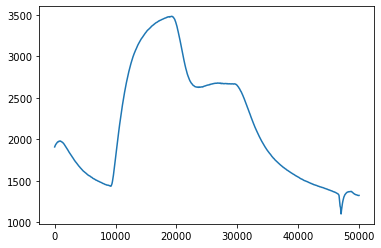

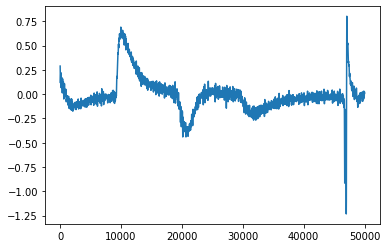

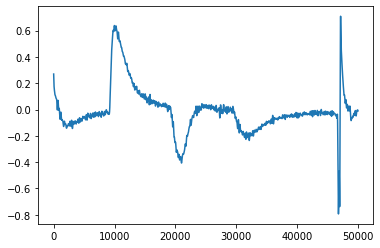

In [ ]:
train_x2 = train_x.copy()
test_x2 = test_x.copy()

b, a = butter(4, 0.1/(100/2), btype='low', analog=False)  # fs = 100 Hz, fc = 10 Hz
filt_train_data = np.array([filtfilt(b, a, train_x[:,16+i]) for i in range(16)]).T
train_x2[:,16:] = filt_train_data
filt_test_data = np.array([filtfilt(b, a, test_x[:,16+i]) for i in range(16)]).T
test_x2[:,16:] = filt_test_data

import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_x[:45000,0])
plt.xlim([0, 45000])
plt.figure()
plt.plot(train_x[:45000,16])
plt.xlim([0, 45000])
plt.figure()
plt.plot(train_x2[:45000,16])
plt.xlim([0, 45000])

In [ ]:
b, a = butter(4, 0.1/(100/2), btype='low', analog=False)  # fs = 100 Hz, fc = 10 Hz
filt_train_data = np.array([filtfilt(b, a, train_x[:,16+i]) for i in range(16)]).T
train_x[:,16:] = filt_train_data
filt_test_data = np.array([filtfilt(b, a, test_x[:,16+i]) for i in range(16)]).T
test_x[:,16:] = filt_test_data

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(train_x)
# train_x = scaler.transform(train_x)
# test_x = scaler.transform(test_x)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [ ]:
# split_p = int(len(train_x)*0.9)
# train_x_t = train_x[:split_p]
# train_y_t = train_y[:split_p]
# train_x_v = train_x[split_p:]
# train_y_v = train_y[split_p:]
# 2:8로 전체 나누었을때 각각 최대한 많은 정보를 담고있는경우를 찾아야함
# 0 11 19
# 1 12 21
# 2 12 20
# 3 11 21
# 4 11 18

split_p = int(len(train_x)*0.2)

train1_x = train_x[:split_p*1,:] 
train2_x = train_x[split_p*2:,:] 
train_x_t = np.concatenate([train1_x,train2_x])
train_x_v = train_x[split_p*1:split_p*2,:]

train1_y = train_y[:split_p*1] 
train2_y = train_y[split_p*2:] 
train_y_t = np.concatenate([train1_y,train2_y],)
train_y_v = train_y[split_p*1:split_p*2]

In [ ]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(data[i:i+window_size])
        label_list.append(label[i:i+window_size])
    return np.array(feature_list), np.array(label_list)

def make_dataset2(data, window_size=20):
    feature_list = []
    for i in range(len(data) - window_size):
        feature_list.append(data[i:i+window_size])
    return np.array(feature_list)

In [ ]:
# train_x_t_seq, train_y_t_seq = make_dataset(train_x_t, train_y_t, 16)
# train_x_v_seq, train_y_v_seq = make_dataset(train_x_v, train_y_v, 16)
# train_x_seq, train_y_seq = make_dataset(train_x, train_y, 16)
# test_x_seq = make_dataset2(test_x, 16)

train_x_t_seq, train_y_t_seq = train_x_t, train_y_t
train_x_v_seq, train_y_v_seq = train_x_v, train_y_v
train_x_seq, train_y_seq = train_x, train_y
test_x_seq = test_x

print(train_x_t_seq.shape)
print(train_y_t_seq.shape)
print(train_x_v_seq.shape)
print(train_y_v_seq.shape)
print(train_x_seq.shape)
print(train_y_seq.shape)
print(test_x_seq.shape)

(2691687, 32)
(2691687,)
(672921, 32)
(672921,)
(3364608, 32)
(3364608,)
(841653, 32)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense , Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Dropout

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(0)

In [ ]:
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_dim=train_x_seq.shape[1]),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='linear')
  ])
 
model. summary() 

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 256)               8448      
                                                                 
 dense_63 (Dense)            (None, 256)               65792     
                                                                 
 dense_64 (Dense)            (None, 1)                 257       
                                                                 
Total params: 74,497
Trainable params: 74,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=0.9)
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(0.01, 40000)
# model.compile(loss='mean_absolute_error', optimizer = Adam(learning_rate=lr_schedule), metrics=['mae'])
model.compile(loss='mean_absolute_error', optimizer = Adam(learning_rate=0.001), metrics=['mae'])

In [ ]:
print(train_x_v_seq.shape)
print(train_y_v.shape)

(672921, 32)
(672921,)


In [ ]:
# 일부 Data로 학습
early_stop = EarlyStopping(monitor='val_loss', patience=10)

model_path = '/content/'
filename = os.path.join(model_path, 'tmp_checkpoint_mlp_train_shft.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(train_x_t_seq, train_y_t_seq,
                    epochs=15, 
                    batch_size=64,
                    validation_data=(train_x_v_seq, train_y_v_seq), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/15
42044/42058 [============================>.] - ETA: 0s - loss: 7.4841 - mae: 7.4841
Epoch 1: val_loss improved from inf to 6.95092, saving model to /content/tmp_checkpoint_mlp_train_shft.h5
42058/42058 [==============================] - 113s 3ms/step - loss: 7.4829 - mae: 7.4829 - val_loss: 6.9509 - val_mae: 6.9509
Epoch 2/15
42040/42058 [============================>.] - ETA: 0s - loss: 3.8232 - mae: 3.8232
Epoch 2: val_loss did not improve from 6.95092
42058/42058 [==============================] - 111s 3ms/step - loss: 3.8240 - mae: 3.8240 - val_loss: 7.5873 - val_mae: 7.5873
Epoch 3/15
42038/42058 [============================>.] - ETA: 0s - loss: 3.1898 - mae: 3.1898
Epoch 3: val_loss improved from 6.95092 to 6.49144, saving model to /content/tmp_checkpoint_mlp_train_shft.h5
42058/42058 [==============================] - 112s 3ms/step - loss: 3.1899 - mae: 3.1899 - val_loss: 6.4914 - val_mae: 6.4914
Epoch 4/15
42051/42058 [============================>.] - ETA: 0s - los

In [ ]:
model.load_weights(filename)
pred = model.predict(test_x_seq)
print(pred.shape)
print(pred.min(), pred.max())

(841653, 1)
-1.8290582 552.6295


In [ ]:
class Y_PRED_CLASSIFIER:
    def __init__(self, y_pred, y_real):
        self.y_pred_clf = self.create_y_pred_clf(y_pred, y_real)

    def create_y_pred_clf(self, y_pred, y_real):
        """
        """
        from sklearn.naive_bayes import GaussianNB
        y_pred_clf = GaussianNB().fit(y_pred.reshape(-1, 1), y_real.astype(str))
        return y_pred_clf

    def post_process_pred_ver4(self, y_pred): 
        """
        y_pred_clf = create_y_pred_clf(y_pred, y_real):
        """
        y_pred_mapped = self.y_pred_clf.predict(y_pred.reshape(-1, 1)).astype(float)
        return y_pred_mapped
      

In [ ]:
pp = model.predict(train_x_seq)
pp2 = np.pad(pp, ((0,train_y.shape[0]-pp.shape[0]),(0,0)), 'constant', constant_values=0)
pp3 = np.squeeze(pp2)

In [ ]:
y_pred_clf = Y_PRED_CLASSIFIER(pp3, train_y) ## create y pred clf 
y_pred = y_pred_clf.post_process_pred_ver4(pred)  # using y pred clf

In [ ]:
sample_submission = pd.read_csv('sample_solution.csv')
y_pred2 = np.pad(y_pred, ((0,sample_submission.shape[0]-y_pred.shape[0])), 'constant', constant_values=0)
sample_submission['CO'] = y_pred2
sample_submission.to_csv('predicted_output.csv', index=False) 
# !kaggle competitions submit -c 2022-samsung-ds-competition-co-gas-data -f predicted_output.csv -m "Test"